### Постановка задачи:
######  Требуется провести EDA качества питьевой воды

$$$$Обзор данных:
1. pH value - значение pH
2. Hardness - жесткость воды
3. Solids (Total dissolved solids - TDS) - Твердые вещества (Общее количество растворенных твердых веществ - TDS)
4. Chloramines - содерджание хлораминов:
5. Sulfate - содержание сульфатов
6. Conductivity - проводимость воды
7. Organic_carbo - органический углерод
8. Trihalomethanes - тригалогенметаны
9. Turbidity - мутность
10. Potability - пригодность для питья ( 1- пригодна, 0 - нет)

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as img
%matplotlib inline
import seaborn as sns


import itertools
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter('ignore')

In [2]:
DATA_ROOT = Path('./Desktop/')
TRAIN_DATASET_PATH = '/Users/annasmejoukha/Desktop/water_potability.csv'

In [3]:
train = pd.read_csv(TRAIN_DATASET_PATH)

In [4]:
train.shape

(3276, 10)

### Обработка  пропусков

In [5]:
train.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

По наиоблее важному признаку 'Sulfate' имеется наибольшее количество пропусков. Для признаков 'ph' и 'Trihalomethanes', как для наименее значимых признаков измерения могли не проводиться или проведение измерений для этих показателей не являлось обязательным. Заменим пропуски средними значениями.

In [6]:
train.loc[train.ph.isnull(), 'ph'] = train['ph'].mean()
train.loc[train.Sulfate.isnull(), 'Sulfate'] = train['Sulfate'].mean()
train.loc[train.Trihalomethanes.isnull(), 'Trihalomethanes'] = train['Trihalomethanes'].mean()

In [7]:
train.isnull().any()

ph                 False
Hardness           False
Solids             False
Chloramines        False
Sulfate            False
Conductivity       False
Organic_carbon     False
Trihalomethanes    False
Turbidity          False
Potability         False
dtype: bool

### Моделирование на исходных данных

In [8]:
X = train.drop('Potability', axis=1)
y = train['Potability']

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state = 42)
print(f" Xtrain:{X_train.shape}, ytrain:{y_train.shape}")

 Xtrain:(2620, 9), ytrain:(2620,)


In [10]:
print(f" Xtest:{X_test.shape}, ytest:{y_test.shape}")

 Xtest:(656, 9), ytest:(656,)


In [11]:
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest Classifier', RandomForestClassifier()),
]

results = dict()
for name, model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    
    score = accuracy_score(y_test, pred)    
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    precision = precision_score(y_test, pred) 
    results[name] = score  

In [12]:
df_results = pd.DataFrame([results])
df_results = df_results.transpose()
df_results = df_results.rename(columns={0:'Score'}).sort_values(by='Score',ascending=False)

In [13]:
df_results.style.set_properties(**{'background-color': '#DEF5E5',
                                    'color': 'black',
                                    'border': '0.5px  solid black'})

,Score
Random Forest Classifier,0.673780
Logistic Regression,0.628049
Decision Tree,0.574695


### Анализ признаков

<AxesSubplot:>

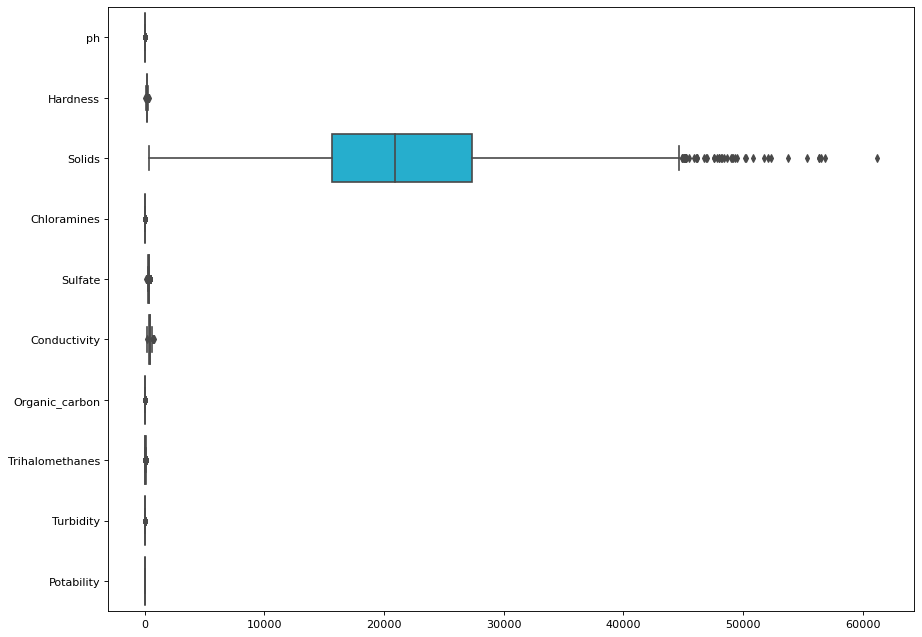

In [14]:
plt.figure(figsize=(13,10), dpi= 80)
sns.boxplot(data=train, palette='rainbow', orient='h')

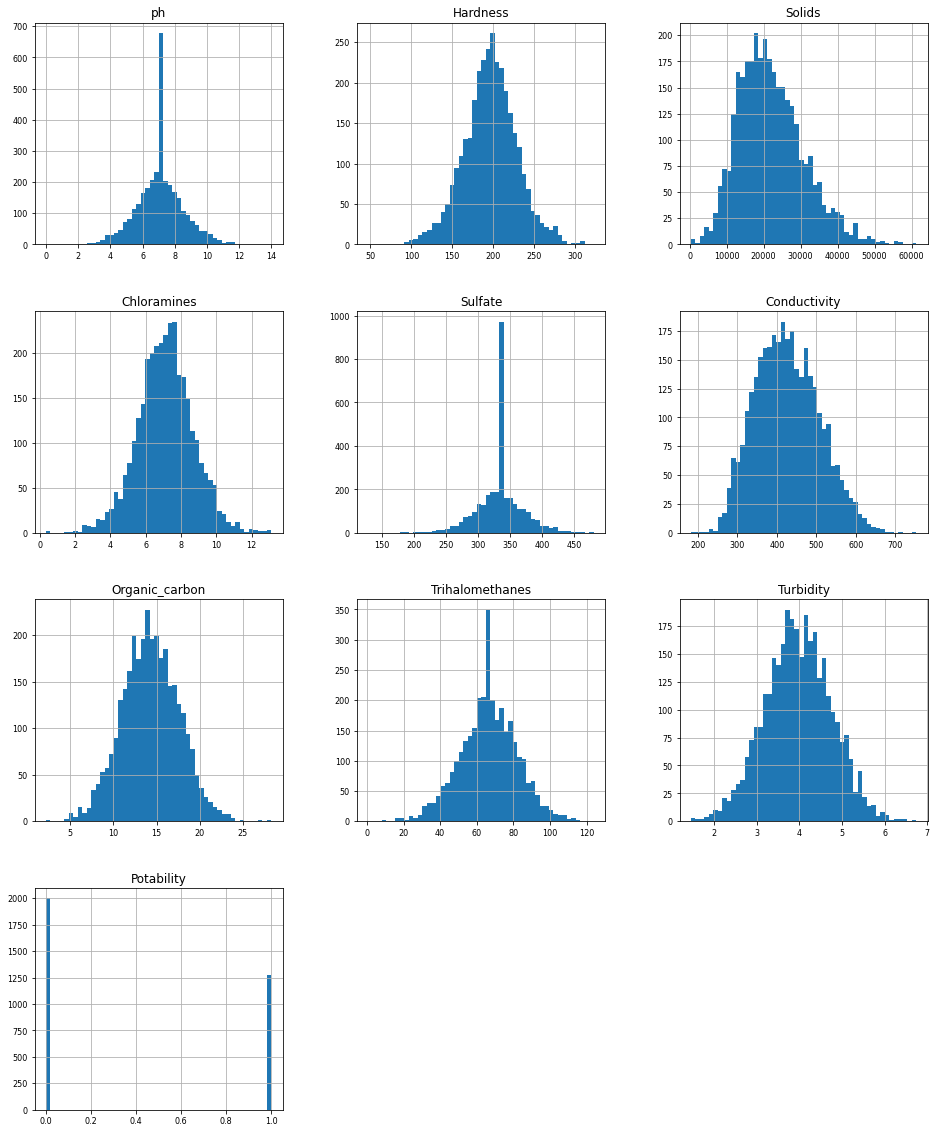

In [15]:
train.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); 

Все признаки, за исключением 'Potability' имеют похожий вид распределения. Так как указанный признак ('Potability' - пригодность для питья) является целевой переменной для данного набора данных

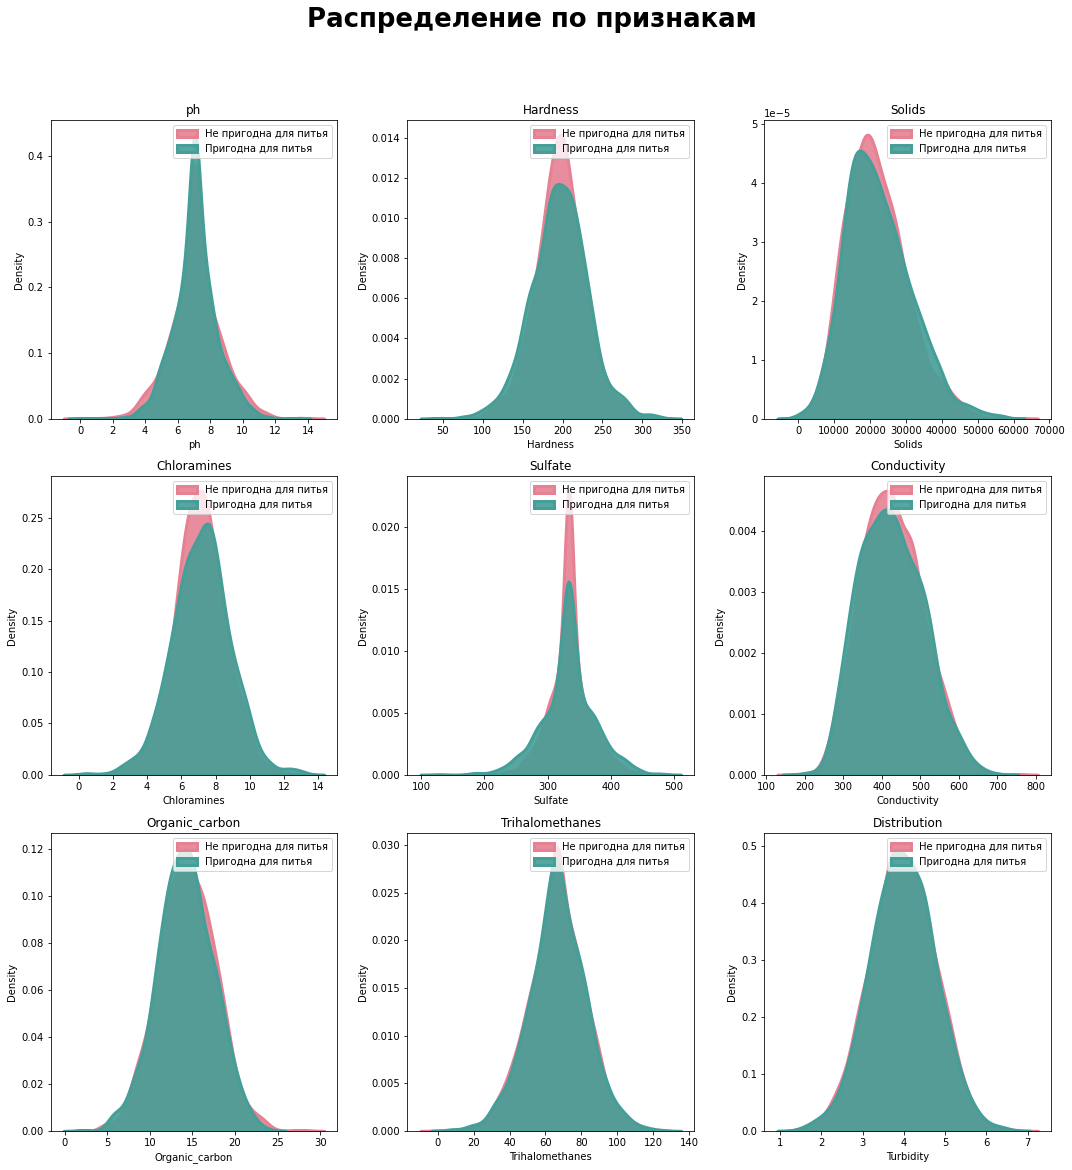

In [16]:
non_potable = train.query("Potability == 0")
potable = train.query("Potability == 1")

plt.figure(figsize = (15,15))
for ax, col in enumerate(train.columns[:9]):
    plt.subplot(3,3, ax + 1)
    plt.title(col)
    plotting = sns.kdeplot(x = non_potable[col], label = "Не пригодна для питья",fill=True, common_norm=False, color="#E68193",alpha=.9, linewidth=3)
    plotting = sns.kdeplot(x = potable[col], label = "Пригодна для питья ",fill=True, common_norm=False, color="#459E97",alpha=.9, linewidth=3)
    plt.legend()
plt.tight_layout()
plt.title('Distribution')
plotting.figure.suptitle('Распределение по признакам ',y=1.08, size = 26, weight='bold');

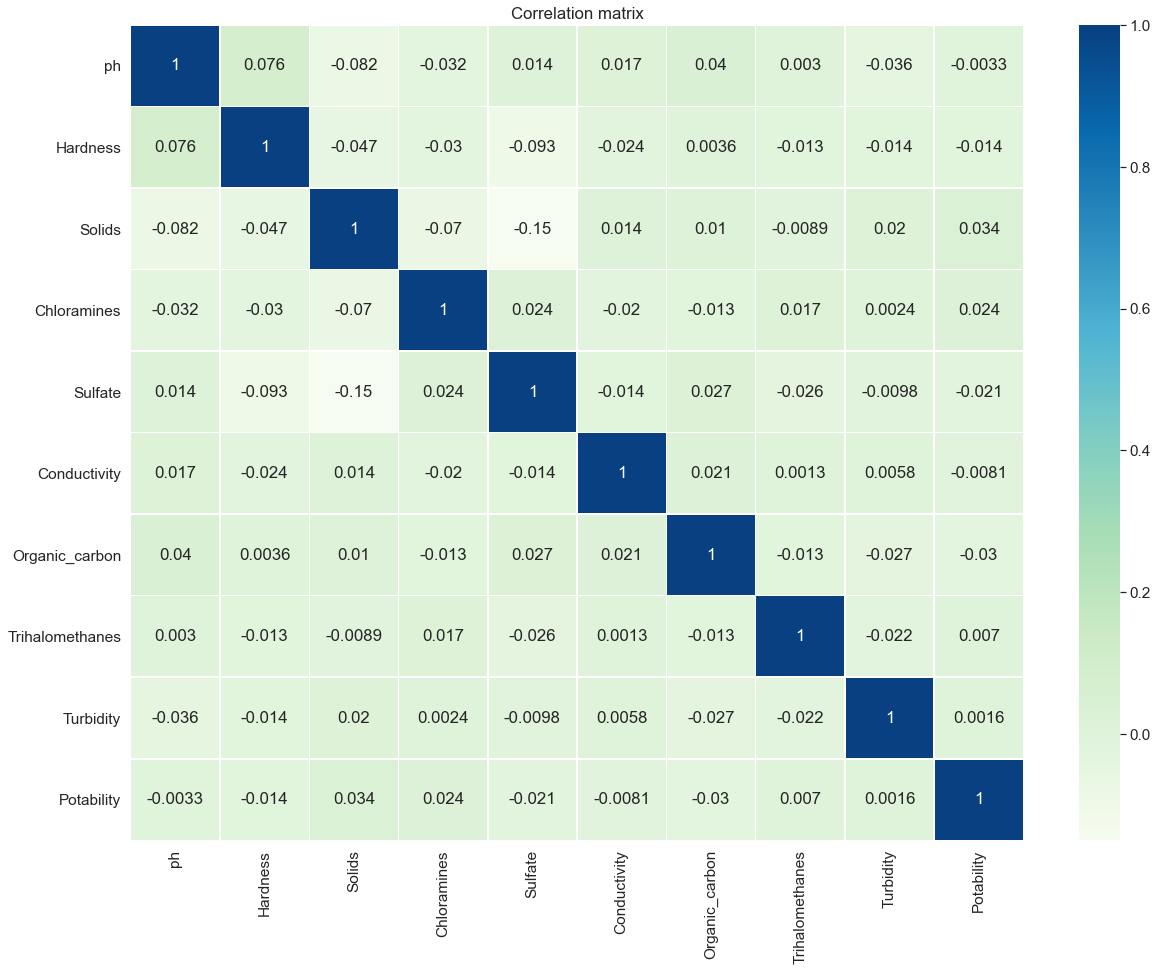

In [17]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(train.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Мы можем наблюдать, что между переменными нет сильной корреляции.
Однако,наиболее коррелированные признаки: содержание твердых веществ,сульфатов (природные вещества, содержащиеся в минералах), жескость воды, проводимость (чистая вода не очень хороший проводник), а также содержание общего органического углерода

##### Анализируя данныe, полученные выше можно заметить ряд зависимостей между признаками:
$$
$$ 1. Взаимосвязь pH воды и жесткость ('Hardness'),так как жесткость воды связана с ее кислотностью. Чем более жесткой является вода, тем она более щелочная. $$
$$ 2. Влияние концетрации примесей ('Solids') и наличие хлораминов ('Cloramines' - неорганисческое соединение, хлоропроизводное аммиака) на пригодность для питья. Концентрация отдельных примесей в воде определяет её свойства, т.е. качество. $$


In [18]:
train_num_corr = train.corr()['Potability'][:-1] 
features_list = train_num_corr[abs(train_num_corr) > 0].sort_values(ascending=False)
print("There is {} strongly correlated values with Potability:\n{}".format(len(features_list), features_list))

There is 9 strongly correlated values with Potability:
Solids             0.033743
Chloramines        0.023779
Trihalomethanes    0.006960
Turbidity          0.001581
ph                -0.003287
Conductivity      -0.008128
Hardness          -0.013837
Sulfate           -0.020619
Organic_carbon    -0.030001
Name: Potability, dtype: float64


Полученный список коррелированных значений неполон, так как мы не учитываем выбросы. Для этого проанализируем ниже графики числовых характеристик по каждому признаку и проведем их анализ.

### Обработка выбросов по наиболее значимым признакам

<AxesSubplot:>

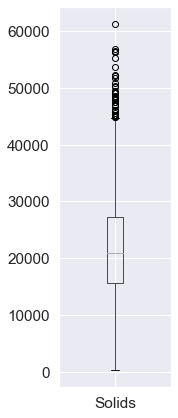

In [19]:
train.boxplot(column=['Solids'], figsize = (2, 7))

<AxesSubplot:>

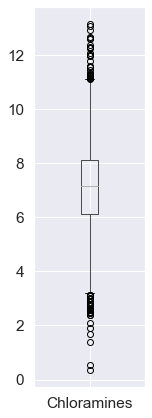

In [20]:
train.boxplot(column=['Chloramines'], figsize = (2, 7))

<AxesSubplot:>

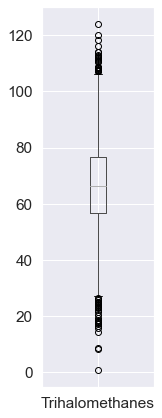

In [21]:
train.boxplot(column=['Trihalomethanes'], figsize = (2, 7))

<AxesSubplot:>

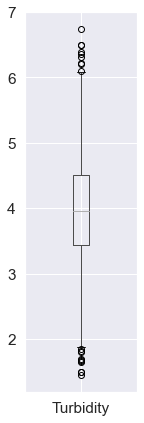

In [22]:
train.boxplot(column=['Turbidity'], figsize = (2, 7))

Попробуем избавиться от выбросов для данных признаков и снова посмотрим на их коррелируемые значения

In [23]:
q_s_low = train["Solids"].quantile(0.05)
q_s_hi  = train["Solids"].quantile(0.95)

df_filtered = train[(train["Solids"] < q_s_hi) & (train["Solids"] > q_s_low)]

In [24]:
q_c_low = train["Chloramines"].quantile(0.04)
q_c_hi  = train["Chloramines"].quantile(0.98)

df_filtered = train[(train["Chloramines"] < q_c_hi) & (train["Chloramines"] > q_c_low)]

In [25]:
q_t_low = train["Trihalomethanes"].quantile(0.01)
q_t_hi  = train["Trihalomethanes"].quantile(0.99)

df_filtered = train[(train["Trihalomethanes"] < q_t_hi) & (train["Trihalomethanes"] > q_t_low)]

In [26]:
q_tu_low = train["Turbidity"].quantile(0.01)
q_tu_hi  = train["Turbidity"].quantile(0.99)

df_filtered = train[(train["Turbidity"] < q_tu_hi) & (train["Turbidity"] > q_tu_low)]

<AxesSubplot:>

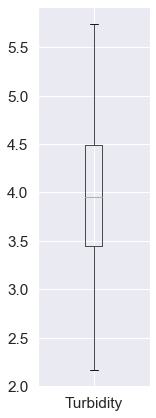

In [27]:
df_filtered.boxplot(column=["Turbidity"], figsize = (2, 7))

In [28]:
df_filt_num_corr = df_filtered.corr()['Potability'][:-1] 
features_list = df_filt_num_corr[abs(df_filt_num_corr) > 0].sort_values(ascending=False)
print("There is {} strongly correlated values with Potability:\n{}".format(len(features_list), features_list))

There is 9 strongly correlated values with Potability:
Solids             0.037471
Chloramines        0.027381
Trihalomethanes    0.012848
Turbidity          0.003564
ph                -0.003496
Conductivity      -0.004884
Hardness          -0.013576
Sulfate           -0.020559
Organic_carbon    -0.023671
Name: Potability, dtype: float64


Сравнивая с предыдущими значениями, за счет исключения выбросов коррелирующие значение повысились (не существенно,различие в тысячных)

### Моделирование на "очищенных данных"

In [29]:
X = df_filtered.drop('Potability', axis=1)
y = df_filtered['Potability']

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state = 42)
print(f" Xtrain:{X_train.shape}, ytrain:{y_train.shape}")

 Xtrain:(2568, 9), ytrain:(2568,)


In [31]:
print(f" Xtest:{X_test.shape}, ytest:{y_test.shape}")

 Xtest:(642, 9), ytest:(642,)


In [32]:
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest Classifier', RandomForestClassifier()),
]

results = dict()
for name, model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    
    score = accuracy_score(y_test, pred)    
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    precision = precision_score(y_test, pred) 
    results[name] = score  

In [33]:
#storing the results into dataframe
df_results = pd.DataFrame([results])
df_results = df_results.transpose()
df_results = df_results.rename(columns={0:'Score'}).sort_values(by='Score',ascending=False)

In [34]:
df_results.style.set_properties(**{'background-color': '#DEF5E5',
                                    'color': 'black',
                                    'border': '0.5px  solid black'})

,Score
Random Forest Classifier,0.696262
Logistic Regression,0.651090
Decision Tree,0.604361


## Выводы:
Анализ показал, что:
данный набор данных является несбалансированным, есть плотность для средних значений.

В ходе проведенного EDA предлагаются следующие дальнейшие шаги:
1. Выбросы оказывают влияние на качество модели (моделирование на подготовленных данных позволило улучшить качество моделей от 3 до 4 % для всех использованных моделей)
2. Ввиду корреляционной связи между некоторыми признаками (например: pH  и жескость воды) возможно целесобразно будет их группировка в один признак
3. Требуется стандартизация данных или  масштабирование, так как существует большая разница между максимальными значениями.